In [275]:
# Impor library yang diperlukan
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, Dropout, Dense
import matplotlib.pyplot as plt

In [276]:
# Untuk menampilkan dataframe
df = pd.read_csv('bbc-text.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [277]:
# Untuk menampilkan jumlah colomns dan data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [278]:
# Panggil fungsi head() pada dataframe untuk menampilkan 5 sampel teratas pada dataset
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [279]:
# Melakukan hot encording karena label kita merupakan data kategorikal
category = pd.get_dummies(df.category)
category

,business,entertainment,politics,sport,tech
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
2220,1,0,0,0,0
2221,0,0,1,0,0
2222,0,1,0,0,0
2223,0,0,1,0,0


In [280]:
# Menampilkan jumlah per kategori
print("1. Business\t\t", len(df[df.category == 'business']))
print("2. Entertainment\t", len(df[df.category == 'entertainment'])) 
print("3. Politics\t\t", len(df[df.category == 'politics'])) 
print("4. Sport\t\t", len(df[df.category == 'sport'])) 
print("5. Tech\t\t\t", len(df[df.category == 'tech'])) 

1. Business		 510
2. Entertainment	 386
3. Politics		 417
4. Sport		 511
5. Tech			 401


In [281]:
# Melakukan one-hot-encoding dan membuat dataframe baru
category = pd.get_dummies(df.category)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns=['category'])
new_df

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [282]:
# Agar dapat diproses oleh model, kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values
text = new_df['text'].values
label = new_df[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [283]:
# Kemudian bagi data untuk training dan data untuk testing
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [284]:
# Kemudian kita ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer
# Setelah tokenisasi selesai, kita perlu membuat mengonversi setiap sampel menjadi sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_latih) 
tokenizer.fit_on_texts(text_test)
 
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)
 
padded_latih = pad_sequences(sekuens_latih, maxlen=50, padding='post', truncating='post') 
padded_test = pad_sequences(sekuens_test, maxlen=50, padding='post', truncating='post')

In [285]:
# Untuk arsitektur model kita menggunakan layer Embedding dengan dimensi embedding sebesar 32, serta dimensi dari input sebesar nilai num_words pada objek tokenizer
# Activation function yang digunakan pada layer terakhir dipilih softmax karena activation tersebut umum dipakai untuk klasifikasi multi kelas seperti ini
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [286]:
# Menentukan optimizer dan loss function dari model. Untuk masalah klasifikasi multi kelas, menggunakan loss ‘categorical_crossentropy’
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [287]:
# Mengimplementasikan callback
# Dan mengset bila val_accuracy mencapai 92% otomatis akan stop training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.92):
      if(logs.get('accuracy')>0.92):
        print("\nval_accuracy telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [288]:
# Menggunakan 30 epoch. atau bebas bereksperimen dengan nilai yang lain
# Mulai melatih model kita dengan memanggil fungsi fit()
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
56/56 - 7s - loss: 1.6032 - accuracy: 0.2337 - val_loss: 1.5741 - val_accuracy: 0.4000
Epoch 2/30
56/56 - 5s - loss: 1.1782 - accuracy: 0.4933 - val_loss: 0.8450 - val_accuracy: 0.6292
Epoch 3/30
56/56 - 5s - loss: 0.5451 - accuracy: 0.7579 - val_loss: 0.6637 - val_accuracy: 0.7101
Epoch 4/30
56/56 - 5s - loss: 0.3297 - accuracy: 0.8635 - val_loss: 0.6146 - val_accuracy: 0.7955
Epoch 5/30
56/56 - 5s - loss: 0.1899 - accuracy: 0.9472 - val_loss: 0.5447 - val_accuracy: 0.8562
Epoch 6/30
56/56 - 5s - loss: 0.1197 - accuracy: 0.9775 - val_loss: 0.7159 - val_accuracy: 0.8382
Epoch 7/30
56/56 - 5s - loss: 0.1046 - accuracy: 0.9669 - val_loss: 0.6676 - val_accuracy: 0.8494
Epoch 8/30
56/56 - 5s - loss: 0.0545 - accuracy: 0.9860 - val_loss: 0.7011 - val_accuracy: 0.8787
Epoch 9/30
56/56 - 5s - loss: 0.0793 - accuracy: 0.9815 - val_loss: 0.4826 - val_accuracy: 0.9011
Epoch 10/30
56/56 - 5s - loss: 0.0400 - accuracy: 0.9893 - val_loss: 0.6255 - val_accuracy: 0.8921
Epoch 11/30
56/56 -

In [289]:
#  Menguji akurasi prediksi model pada data uji
#  Karena kita dapat membuat plot dari akurasi dan loss model kita pada saat proses pelatihan
model.evaluate(padded_latih, label_latih)

56/56 [==============================] - 1s 21ms/step - loss: 7.6304e-05 - accuracy: 1.0000


[7.630439358763397e-05, 1.0]

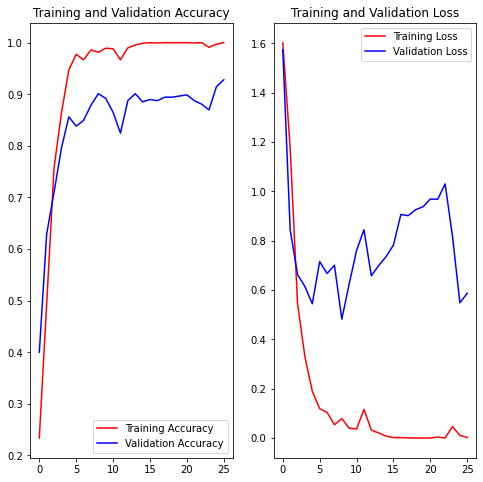

In [290]:
# Membuat plot akurasi atau loss dari model. Kode di bawah menunjukkan bagaimana kita bisa membuat plot loss dan accuracy dari model
# Untuk membuat loss kita bisa memanggil fungsi history pada objek history
# Untuk membuat plot dari akurasi kita bisa memilih metrik accuracy pada fungsi history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(26)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()